In [85]:
from pyspark.sql import SQLContext
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.types import DateType
from datetime import date, timedelta
import datetime as dt
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import GBTRegressor
from pyspark.sql.functions import col, avg, sum
import numpy as np
import matplotlib.dates as mdates
from matplotlib import pyplot as plt
import pandas as pd

## Read Feature File

In [2]:
base_path = "/home/darkmatter/Desktop/smart-meters-in-london/Feature_FIle/"
sqlcontext = SQLContext(sc)

In [3]:
df = []
for mth in range(1,13):
    month_df = sqlcontext.read.csv(base_path+"Cleaned_2013_Features_mth_{}.csv".format(mth),header = True,inferSchema=True)
    if mth == 1:
        df = sqlcontext.createDataFrame(df,month_df.schema)
    df = df.union(month_df)
    break

In [4]:
df = df.drop("_c0")
df.printSchema()

root
 |-- LCLid: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- hour: integer (nullable = true)
 |-- energy(kWh/h): double (nullable = true)
 |-- month: integer (nullable = true)
 |-- weekDay: string (nullable = true)
 |-- 1_diff_energy_t_0: double (nullable = true)
 |-- 2_diff_energy_t_0: double (nullable = true)
 |-- 1_diff_energy_t_1: double (nullable = true)
 |-- 2_diff_energy_t_1: double (nullable = true)
 |-- 1_diff_energy_t_2: double (nullable = true)
 |-- 2_diff_energy_t_2: double (nullable = true)
 |-- diff_energy_week_t_1: double (nullable = true)
 |-- diff_energy_week_t_2: double (nullable = true)
 |-- diff_energy_week_t_3: double (nullable = true)
 |-- diff_energy_week_t_4: double (nullable = true)
 |-- mean_1: double (nullable = true)
 |-- mean_2: double (nullable = true)
 |-- min_1: double (nullable = true)
 |-- max_1: double (nullable = true)
 |-- min_2: double (nullable = true)
 |-- max_2: double (nullable = true)
 |-- count: integer (nullable = tr

## Disaggregated Approach using RF

## Perform :
    * 1 hot encoding
    * Vector Assembler

In [5]:
outputCols = ["weekDay_index","precipType_index","summary_index","stdorToU_index","Acorn_grouped_index"]
for col in outputCols: 
    encoder = OneHotEncoder(inputCol=col, outputCol="category_{}".format(col))
    df_encoded = encoder.transform(df).cache()
df_encoded.printSchema()

root
 |-- LCLid: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- hour: integer (nullable = true)
 |-- energy(kWh/h): double (nullable = true)
 |-- month: integer (nullable = true)
 |-- weekDay: string (nullable = true)
 |-- 1_diff_energy_t_0: double (nullable = true)
 |-- 2_diff_energy_t_0: double (nullable = true)
 |-- 1_diff_energy_t_1: double (nullable = true)
 |-- 2_diff_energy_t_1: double (nullable = true)
 |-- 1_diff_energy_t_2: double (nullable = true)
 |-- 2_diff_energy_t_2: double (nullable = true)
 |-- diff_energy_week_t_1: double (nullable = true)
 |-- diff_energy_week_t_2: double (nullable = true)
 |-- diff_energy_week_t_3: double (nullable = true)
 |-- diff_energy_week_t_4: double (nullable = true)
 |-- mean_1: double (nullable = true)
 |-- mean_2: double (nullable = true)
 |-- min_1: double (nullable = true)
 |-- max_1: double (nullable = true)
 |-- min_2: double (nullable = true)
 |-- max_2: double (nullable = true)
 |-- count: integer (nullable = tr

In [6]:
inputCols = ["weekDay","precipType","summary","stdorToU","Acorn_grouped","count"]
columns = df_encoded.columns
feature_col = columns[4:]
feature_col.append(columns[2])
feature_col = set(feature_col) - set(inputCols)
feature_col = feature_col - set(outputCols)
feature_col = list(feature_col)
feature_col.remove("date2")
len(feature_col)

30

In [7]:
# Dropping row with Na
df_encoded = df_encoded.na.drop()

In [8]:
vecAssembler = VectorAssembler(inputCols=feature_col, outputCol="features")
df_feature = vecAssembler.transform(df_encoded)
df_feature.take(1)

[Row(LCLid='MAC001858', date=datetime.datetime(2013, 1, 1, 0, 0), hour=0, energy(kWh/h)=0.968, month=1, weekDay='Tue', 1_diff_energy_t_0=0.761, 2_diff_energy_t_0=0.825, 1_diff_energy_t_1=0.57, 2_diff_energy_t_1=1.241, 1_diff_energy_t_2=0.606, 2_diff_energy_t_2=1.489, diff_energy_week_t_1=0.436, diff_energy_week_t_2=2.26, diff_energy_week_t_3=0.85, diff_energy_week_t_4=0.464, mean_1=0.6940833333333334, mean_2=0.6582500000000001, min_1=0.328, max_1=1.569, min_2=0.3, max_2=1.609, count=8760, visibility=13.28, windBearing=269, dewPoint=2.6, pressure=1008.19, apparentTemperature=3.66, windSpeed=5.46, precipType='rain', humidity=0.73, summary='Partly Cloudy', date2=datetime.datetime(2013, 1, 1, 0, 0), temperatureMax=7.49, temperatureMin=3.31, holiday=1, Weekday/end=0, stdorToU='ToU', Acorn_grouped='Comfortable', weekDay_index=4.0, precipType_index=0.0, summary_index=2.0, stdorToU_index=1.0, Acorn_grouped_index=2.0, category_Acorn_grouped_index=SparseVector(2, {}), features=DenseVector([0.73,

In [9]:
df_feature = df_feature.withColumnRenamed("energy(kWh/h)","label")
df_feature = df_feature.withColumn("date",df_feature["date"].cast(DateType()))
df_feature.printSchema()

root
 |-- LCLid: string (nullable = true)
 |-- date: date (nullable = true)
 |-- hour: integer (nullable = true)
 |-- label: double (nullable = true)
 |-- month: integer (nullable = true)
 |-- weekDay: string (nullable = true)
 |-- 1_diff_energy_t_0: double (nullable = true)
 |-- 2_diff_energy_t_0: double (nullable = true)
 |-- 1_diff_energy_t_1: double (nullable = true)
 |-- 2_diff_energy_t_1: double (nullable = true)
 |-- 1_diff_energy_t_2: double (nullable = true)
 |-- 2_diff_energy_t_2: double (nullable = true)
 |-- diff_energy_week_t_1: double (nullable = true)
 |-- diff_energy_week_t_2: double (nullable = true)
 |-- diff_energy_week_t_3: double (nullable = true)
 |-- diff_energy_week_t_4: double (nullable = true)
 |-- mean_1: double (nullable = true)
 |-- mean_2: double (nullable = true)
 |-- min_1: double (nullable = true)
 |-- max_1: double (nullable = true)
 |-- min_2: double (nullable = true)
 |-- max_2: double (nullable = true)
 |-- count: integer (nullable = true)
 |-- visi

##  actual and Predicted for given day

In [57]:
def get_aggregate(df):
    list = ["date","hour"]
    df = df.groupBy(list).agg(sum("label"),sum("prediction"))    
    return df

def select_predicted_actual(df,date,LCLid=None):
    list = []
    if LCLid != None:
        list = df.where((df["LCLid"] == LCLid) & (df["date"] == date)).select("label","prediction").collect()
    else:
        list = df.where((df["date"] == date)).select("label","prediction").collect()
    actual = [int(row['label']) for row in list]
    predicted = [int(row['prediction']) for row in list]
    return actual,predicted

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def root_mean_squared_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.sqrt(np.mean(np.abs((y_true - y_pred)**2)))

## Train-Test Split

In [10]:
train_df = df_feature.where(df_feature["date"] <= date(2013,1,1))
test_df = df_feature.where((df_feature["date"] > date(2013,1,1)) & (df_feature["date"] <= date(2013,1,2)))
splits = train_df.randomSplit([0.01, 0.01,0.98], 24)
splits[0].count()

957

## RandomForest

In [11]:
rf = RandomForestRegressor(seed=123)
paramGrid = ParamGridBuilder()\
    .addGrid(rf.numTrees,[10,20,50]) \
    .addGrid(rf.maxDepth,[10,15,20])\
    .addGrid(rf.maxBins,[64,128])\
    .addGrid(rf.featureSubsetStrategy,["auto","sqrt"])\
    .build()
tvs = TrainValidationSplit(estimator=rf,
                           estimatorParamMaps=paramGrid,
                           evaluator=RegressionEvaluator(),
                           # 80% of the data will be used for training, 20% for validation.
                           trainRatio=0.8)
model = tvs.fit(splits[0])

In [12]:
model.save(base_path+"model")

In [17]:
best_model = model.bestModel
print(" RF optimal num_trees = {}".format(best_model.getNumTrees))

 RF optimal num_trees = 20


In [28]:
{param[0].name: param[1] for param in best_model.extractParamMap().items()}

{'cacheNodeIds': False,
 'checkpointInterval': 10,
 'featureSubsetStrategy': 'auto',
 'featuresCol': 'features',
 'impurity': 'variance',
 'labelCol': 'label',
 'maxBins': 64,
 'maxDepth': 10,
 'maxMemoryInMB': 256,
 'minInfoGain': 0.0,
 'minInstancesPerNode': 1,
 'numTrees': 20,
 'predictionCol': 'prediction',
 'seed': 123,
 'subsamplingRate': 1.0}

In [30]:
pred_val = best_model.transform(splits[1])
pred_val.printSchema()
evaluator = RegressionEvaluator(labelCol='label', predictionCol='prediction', metricName="rmse")
accuracy = evaluator.evaluate(pred_val)

root
 |-- LCLid: string (nullable = true)
 |-- date: date (nullable = true)
 |-- hour: integer (nullable = true)
 |-- label: double (nullable = true)
 |-- month: integer (nullable = true)
 |-- weekDay: string (nullable = true)
 |-- 1_diff_energy_t_0: double (nullable = true)
 |-- 2_diff_energy_t_0: double (nullable = true)
 |-- 1_diff_energy_t_1: double (nullable = true)
 |-- 2_diff_energy_t_1: double (nullable = true)
 |-- 1_diff_energy_t_2: double (nullable = true)
 |-- 2_diff_energy_t_2: double (nullable = true)
 |-- diff_energy_week_t_1: double (nullable = true)
 |-- diff_energy_week_t_2: double (nullable = true)
 |-- diff_energy_week_t_3: double (nullable = true)
 |-- diff_energy_week_t_4: double (nullable = true)
 |-- mean_1: double (nullable = true)
 |-- mean_2: double (nullable = true)
 |-- min_1: double (nullable = true)
 |-- max_1: double (nullable = true)
 |-- min_2: double (nullable = true)
 |-- max_2: double (nullable = true)
 |-- count: integer (nullable = true)
 |-- visi

In [31]:
print(accuracy)

0.3922658477673789


## Gradient Boosted Tree

In [34]:
gbt = GBTRegressor(seed=123)
paramGrid = ParamGridBuilder()\
    .addGrid(gbt.maxIter,[10,20,50]) \
    .addGrid(gbt.maxDepth,[10,15,20])\
    .addGrid(gbt.maxBins,[64,128])\
    .build()
tvs = TrainValidationSplit(estimator=gbt,
                           estimatorParamMaps=paramGrid,
                           evaluator=RegressionEvaluator(),
                           # 80% of the data will be used for training, 20% for validation.
                           trainRatio=0.8)
gbt_model = tvs.fit(splits[0])

In [36]:
gbt_model.save(base_path+"gbt_model")

In [37]:
{param[0].name: param[1] for param in gbt_model.bestModel.extractParamMap().items()}

{'cacheNodeIds': False,
 'checkpointInterval': 10,
 'featuresCol': 'features',
 'impurity': 'variance',
 'labelCol': 'label',
 'lossType': 'squared',
 'maxBins': 128,
 'maxDepth': 10,
 'maxIter': 10,
 'maxMemoryInMB': 256,
 'minInfoGain': 0.0,
 'minInstancesPerNode': 1,
 'predictionCol': 'prediction',
 'seed': 123,
 'stepSize': 0.1,
 'subsamplingRate': 1.0}

In [38]:
pred_val = gbt_model.bestModel.transform(splits[1])
pred_val.printSchema()
evaluator = RegressionEvaluator(labelCol='label', predictionCol='prediction', metricName="rmse")
accuracy = evaluator.evaluate(pred_val)

root
 |-- LCLid: string (nullable = true)
 |-- date: date (nullable = true)
 |-- hour: integer (nullable = true)
 |-- label: double (nullable = true)
 |-- month: integer (nullable = true)
 |-- weekDay: string (nullable = true)
 |-- 1_diff_energy_t_0: double (nullable = true)
 |-- 2_diff_energy_t_0: double (nullable = true)
 |-- 1_diff_energy_t_1: double (nullable = true)
 |-- 2_diff_energy_t_1: double (nullable = true)
 |-- 1_diff_energy_t_2: double (nullable = true)
 |-- 2_diff_energy_t_2: double (nullable = true)
 |-- diff_energy_week_t_1: double (nullable = true)
 |-- diff_energy_week_t_2: double (nullable = true)
 |-- diff_energy_week_t_3: double (nullable = true)
 |-- diff_energy_week_t_4: double (nullable = true)
 |-- mean_1: double (nullable = true)
 |-- mean_2: double (nullable = true)
 |-- min_1: double (nullable = true)
 |-- max_1: double (nullable = true)
 |-- min_2: double (nullable = true)
 |-- max_2: double (nullable = true)
 |-- count: integer (nullable = true)
 |-- visi

In [39]:
print(accuracy)

0.7185794278960247


In [45]:
pred_val.select("LCLid","label","prediction").show()

+---------+-----+--------------------+
|    LCLid|label|          prediction|
+---------+-----+--------------------+
|MAC000057|0.501|  0.4773765659257565|
|MAC000064|0.115|  0.1982559353437227|
|MAC000076| 0.76|  0.6749267247226459|
|MAC000093|0.167| 0.15023058409684778|
|MAC000165| 0.88|  0.7887232561519145|
|MAC000171|0.024| 0.15204646835031654|
|MAC000257|1.645|  1.4041587870834569|
|MAC000283|0.391| 0.45375589712800407|
|MAC000291|0.518|  0.5062796742622596|
|MAC000298|0.121|  0.2894706208945847|
|MAC000367|0.543|   0.277242949945831|
|MAC000372| 0.43| 0.38760676213083367|
|MAC000374|0.401| 0.10874167145956481|
|MAC000403|0.117| 0.21497708459278078|
|MAC000404|0.019| 0.01449894280200095|
|MAC000421|0.088| 0.06815686387864044|
|MAC000428|1.138|  0.5697963992112618|
|MAC000515| 0.02|0.014446547832215429|
|MAC000515| 0.02| 0.15969045661670433|
|MAC000536| 0.28|  0.4032105773180854|
+---------+-----+--------------------+
only showing top 20 rows



In [51]:
aggregate_df = get_aggregate(pred_val)
aggregate_df = aggregate_df.withColumnRenamed("sum(label)","label")
aggregate_df = aggregate_df.withColumnRenamed("sum(prediction)","prediction")

## Own Metric

In [60]:
train_start_date = date(2013,1,1)
train_end_date = date(2013,1,2)
y_date = []
Mape_date = []
rmse_date = []
while train_start_date <= train_end_date:
    y_actual,y_pred = select_predicted_actual(aggregate_df,train_start_date)
    if len(y_actual) == 0:
        break
    Mape_date.append(mean_absolute_percentage_error(y_actual,y_pred))
    rmse_date.append(root_mean_squared_error(y_actual,y_pred))
    y_date.append(train_start_date)
    train_start_date = train_start_date + timedelta(1)

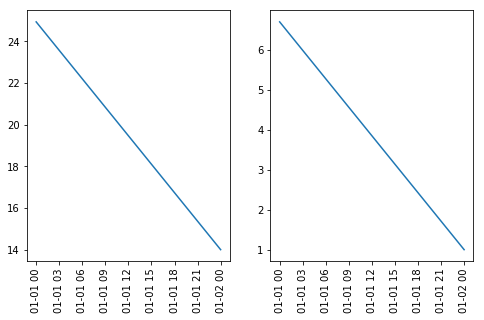

In [112]:
#del y_date[2]
# fig, (ax1,ax2) = plt.subplots(1,2, figsize =(8,6))
# ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
# ax1.xaxis.set_major_locator(mdates.DayLocator())
# ax2.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
# ax2.xaxis.set_major_locator(mdates.DayLocator())
# ax1.plot(y_date,Mape_date)
# ax2.plot(y_date,rmse_date)
# fig.autofmt_xdate()
# ax1.set_xlabel('k')
# ax1.set_ylabel('cost')
date_time = pd.to_datetime(y_date)
DF = pd.DataFrame()
DF['Mape_date'] = Mape_date
DF = DF.set_index(date_time)

DF1 = pd.DataFrame()
DF1['rmse_date'] = rmse_date
DF1 = DF1.set_index(date_time)
fig, (ax1,ax2) = plt.subplots(1,2, figsize =(8,6))
fig.subplots_adjust(bottom=0.3)
for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=90)
ax1.plot(DF)
ax2.plot(DF1)